In [ ]:
import os
import pdb

import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

## Constants

In [ ]:
years = np.arange(1901, 2016)
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

## Load

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '1tg-QWH8sicUM3LgxqKayyLzTpfrM4LKM'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('xaxis.txt')

id = '1ixiONnFAoSJ5Csctb_HKDGmutKUUiVRX'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('yaxis.txt')

id = '13wN-Y1q5aFprVYKEy6dr6lSXPaJNrtEo'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('rainfall_data.npy')

In [ ]:
xaxis = np.loadtxt('xaxis.txt')
yaxis = np.loadtxt('yaxis.txt')
data = np.load('rainfall_data.npy')
print(xaxis.shape, yaxis.shape, data.shape)

(135,) (129,) (115, 12, 129, 135)


In [ ]:
## To test the RNN on one randomised location (given lonigtude & latitude)
working_data = data[:,:,34, 57]
print(working_data.shape)

(115, 12)


In [ ]:
# select a location and work on data for that location
sel_loc = (50, 50)
loc_data = data[:, :, sel_loc[0], sel_loc[1]].ravel()
loc_data = loc_data[:, None]

In [ ]:
# create 70-20-10 split for training-validation-testing
n = loc_data.size
train_data = loc_data[0:int(n*0.7)]
val_data = loc_data[int(n*0.7):int(n*0.9)]
test_data = loc_data[int(n*0.9):]

In [ ]:
# normalize the data using the training data
train_mean = np.mean(train_data)
train_std = np.std(train_data)

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

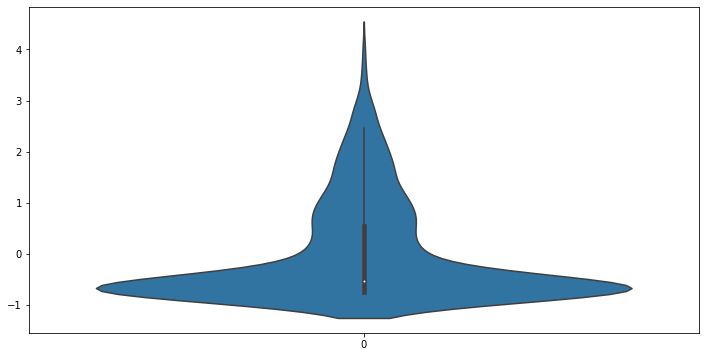

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(data=train_data)

In [ ]:
# generate windows of data for the model
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}'])

In [ ]:
# split windows into input and output for the model
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
def plot(self, model=None, max_subplots=3):
  # pdb.set_trace()
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'Actual Value')
    plt.plot(self.input_indices, inputs[n, :, 0],
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(self.label_indices, labels[n, :, 0],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, 0],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
# build a window generator
w1 = WindowGenerator(input_width=5, label_width=1, shift=1)

In [ ]:
# build a wide window generator
w1_wide = WindowGenerator(input_width=12, label_width=12, shift=1)

In [ ]:
# create a model that takes as input multiple time steps and predicts one step in the future
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', w1.example[0].shape)
print('Output shape:', multi_step_dense(w1.example[0]).shape)

Input shape: (32, 5, 1)
Output shape: (32, 1, 1)


In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(multi_step_dense, w1)

Epoch 1/20
30/30 [==============================] - 0s 7ms/step - loss: 0.4516 - mean_absolute_error: 0.4615 - val_loss: 0.6166 - val_mean_absolute_error: 0.5371
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4611 - mean_absolute_error: 0.4745 - val_loss: 0.6251 - val_mean_absolute_error: 0.5222
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4509 - mean_absolute_error: 0.4655 - val_loss: 0.6176 - val_mean_absolute_error: 0.5254


In [ ]:
IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Multi step dense'] = multi_step_dense.evaluate(w1.val)
performance['Multi step dense'] = multi_step_dense.evaluate(w1.test)

5/5 [==============================] - 0s 1ms/step - loss: 0.6654 - mean_absolute_error: 0.5343


In [ ]:
# create a model with an LSTM
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', w1_wide.example[0].shape)
print('Output shape:', lstm_model(w1_wide.example[0]).shape)

Input shape: (32, 10, 1)
Output shape: (32, 10, 1)


In [ ]:
history = compile_and_fit(lstm_model, w1)

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.9550 - mean_absolute_error: 0.7814 - val_loss: 1.2471 - val_mean_absolute_error: 0.8169
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.9251 - mean_absolute_error: 0.7638 - val_loss: 1.2149 - val_mean_absolute_error: 0.8136
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.9040 - mean_absolute_error: 0.7536 - val_loss: 1.1980 - val_mean_absolute_error: 0.8072
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.8869 - mean_absolute_error: 0.7480 - val_loss: 1.1696 - val_mean_absolute_error: 0.8025
Epoch 5/20
30/30 [==============================] - 0s 7ms/step - loss: 0.8681 - mean_absolute_error: 0.7387 - val_loss: 1.1413 - val_mean_absolute_error: 0.7883
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.8426 - mean_absolute_error: 0.7203 - val_loss: 1.1077 - val_mean_absolute_error: 0.7732
Epoch 7/20
30/30 [=========

In [ ]:
IPython.display.clear_output()
val_performance['LSTM'] = multi_step_dense.evaluate(w1.val)
performance['LSTM'] = multi_step_dense.evaluate(w1.test)

5/5 [==============================] - 0s 1ms/step - loss: 0.6415 - mean_absolute_error: 0.5424


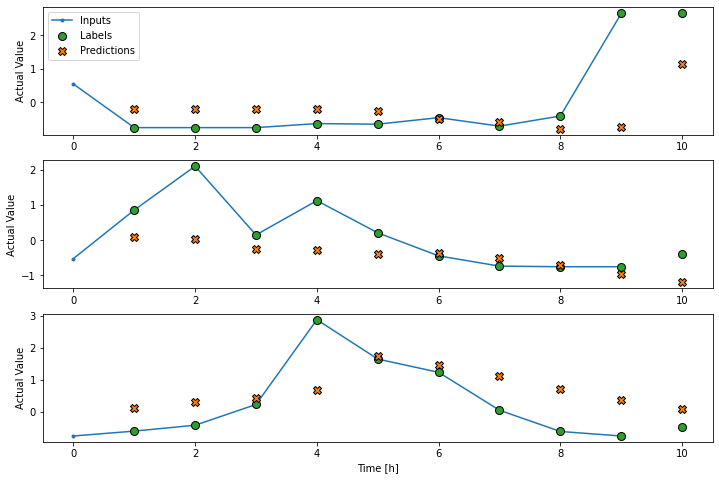

In [ ]:
w1_wide.plot(lstm_model)